Data madness setup

In [462]:
#Imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing


In [463]:
# Load 
complete_data = pd.read_csv("athlete_events.csv")

print(complete_data.columns.values)
#1. ID - Row numbers
#2. Name - Athlete's name
#3. Sex - M or F
#4. Age - Integer
#5. Height - In centimeters
#6. Weight - In kilograms
#7. Team - Team name
#8. NOC - National Olympic Committee 3-letter code
#9. Games - Year and season
#10. Year - Integer
#11. Season - Summer or Winter
#12. City - Host city
#13. Sport - Sport
#14. Event - Event
#15. Medal - Gold, Silver, Bronze, or NA
complete_data.head(3)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_rows', 50)
np.set_printoptions(linewidth=50)
np.set_printoptions(threshold=999)

['ID' 'Name' 'Sex' 'Age' 'Height' 'Weight' 'Team'
 'NOC' 'Games' 'Year' 'Season' 'City' 'Sport'
 'Event' 'Medal']


In [464]:
# Functions

# Medal convertion to numeric columns
def convert_medals(data):
    types = ['', 'Gold', 'Silver', 'Bronze']
    
    cat_type = CategoricalDtype(categories=types)
    
    data['Medal'] = data['Medal'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='mdl',
                          columns=['Medal'], 
                          drop_first=True)
    
    return data

In [465]:
# Clean data

# Sort by olympic event (years) to make it easier to interpret
complete_data = complete_data.sort_values('Games')

# Replacing all NaN values with 0
complete_data = complete_data.fillna(0)

# Convert medals to numerical values
complete_data = convert_medals(complete_data)

# Ideas:
# Ethics -> Electronic clocks only started since 1936 (we could do something with that)

complete_data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,mdl_Gold,mdl_Silver,mdl_Bronze
132219,66542,Leonidas Lanngakis,M,0.0,0.0,0.0,Greece,GRE,1896 Summer,1896,Summer,Athina,Shooting,"Shooting Men's Free Rifle, Three Positions, 30...",0,0,0
214353,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Rings,0,0,0
214352,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Horizontal Bar, Teams",1,0,0
24682,12929,John Mary Pius Boland,M,25.0,0.0,0.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,1,0,0
214351,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Wrestling,"Wrestling Men's Unlimited Class, Greco-Roman",1,0,0


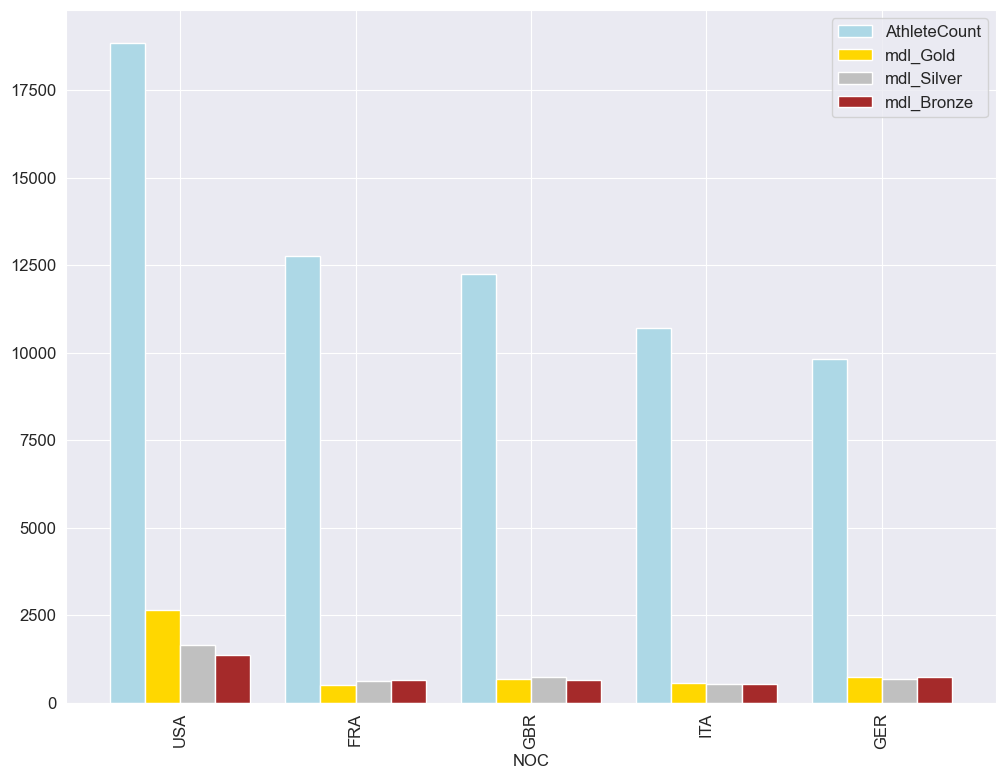

In [466]:
# Medals per country Vs Competing athletes per country
Medals = complete_data[['NOC', 'mdl_Gold', 'mdl_Silver', 'mdl_Bronze']].groupby(['NOC'], as_index=False).sum()

AthleteCount = complete_data['NOC'].value_counts()
AthleteCount = AthleteCount.sort_index()

Medals.insert(1, column='AthleteCount', value=AthleteCount.values)

# Get top 5 in Athlete count and top 5 in Medals
TopAc = Medals.sort_values('AthleteCount', ascending=False).head(5)
TopGold = Medals.sort_values('mdl_Gold', ascending=False).head(5)
TopSilver = Medals.sort_values('mdl_Silver', ascending=False).head(5)
TopBronze = Medals.sort_values('mdl_Bronze', ascending=False).head(5)


fig, ax = plt.subplots()
TopAc.set_index('NOC').plot(kind='bar', ax=ax, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopGold.set_index('NOC').plot(kind='bar', ax=ax2, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopSilver.set_index('NOC').plot(kind='bar', ax=ax3, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopBronze.set_index('NOC').plot(kind='bar', ax=ax4, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
plt.show()



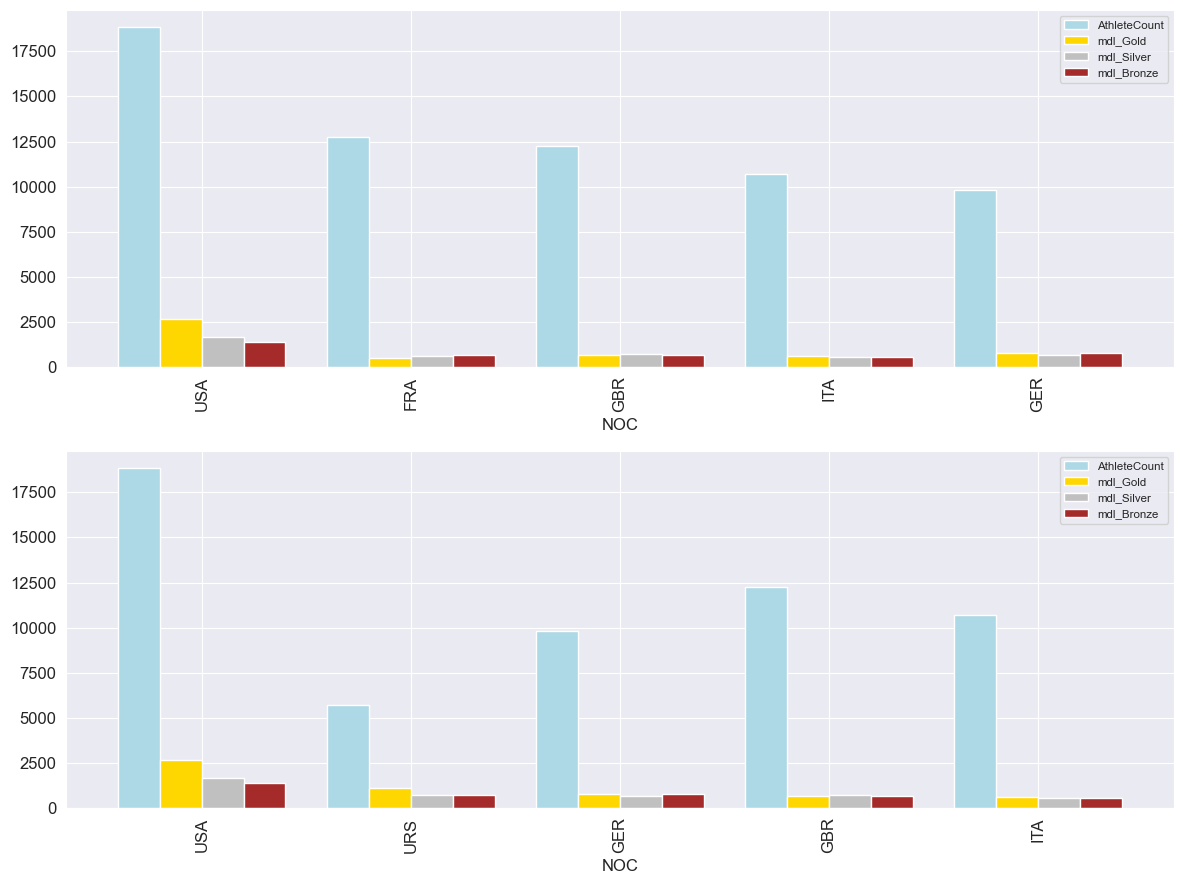

In [467]:
# Amount of athletes vs Amount of medals

fig, (ax1, ax2) = plt.subplots(2)
ax1 = TopAc.set_index('NOC').plot(kind='bar', ax=ax1, width=0.8, color=['lightblue', 'gold', 'silver', 'brown']).legend(fontsize='x-small')
ax2 = TopGold.set_index('NOC').plot(kind='bar', ax=ax2, width=0.8, color=['lightblue', 'gold', 'silver', 'brown']).legend(fontsize='x-small')
fig.tight_layout()
#ax3 = TopSilver.set_index('NOC').plot(kind='bar', ax=ax3, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#ax4 = TopBronze.set_index('NOC').plot(kind='bar', ax=ax4, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])


This graph represents the amount of athletes and the amount of medals a certain country has, during the entire olympics.
The USA is first in both graphs because they just have an absurd amount of athletes that compete.
A little bit further down the graph we can start to see the differences though, france for example has the 2nd highest amount of competing athletes,
but arent even in the top 5 when it comes to gold medals.

URS = Russian soviet union

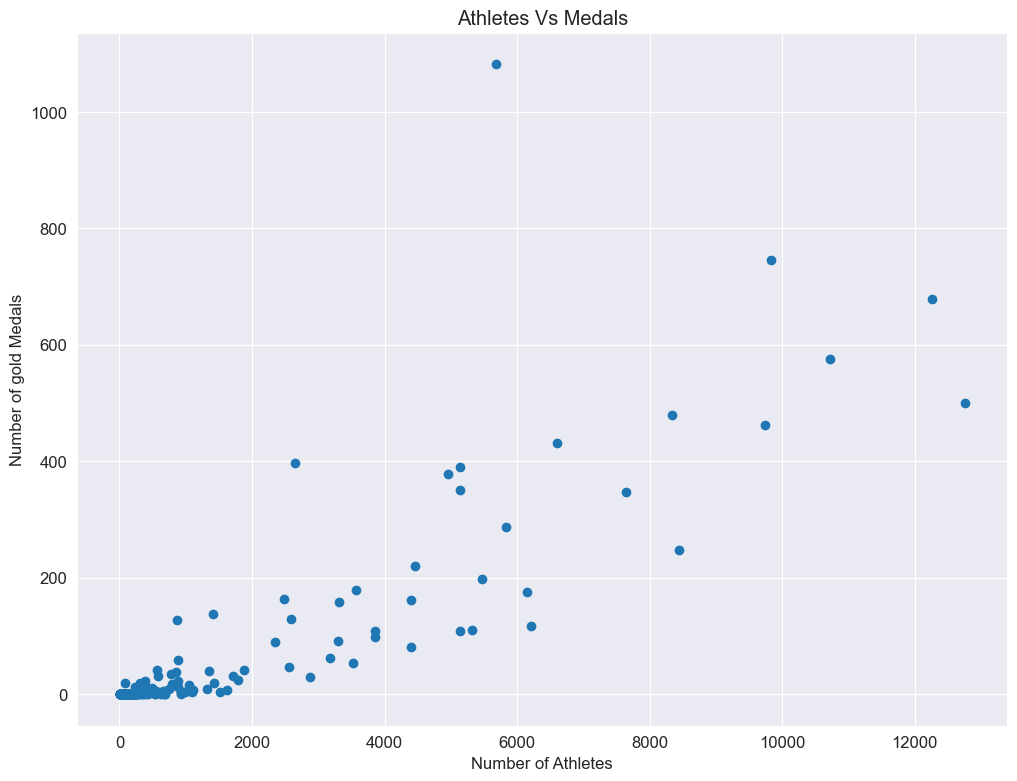

In [468]:
# Comparison plot for athletes vs medals

# Had to remove the USA due it being an extreme outlier
NoUsa = Medals[Medals['NOC'] != 'USA']

corr = NoUsa['AthleteCount'].corr(NoUsa['mdl_Gold'])

plt.scatter(NoUsa['AthleteCount'], NoUsa['mdl_Gold'])
plt.xlabel('Number of Athletes')
plt.ylabel('Number of gold Medals')
plt.title('Athletes Vs Medals')
plt.show()


Relation between amount of athletes vs gold medals does exist as expected, but it is not as strict as one might assume. There are some very high performing countries that do not have that many athletes competing. 

Union of Soviet Republic (pre 1991 Russia) is a good example of this (it is the upper dot in the middle).
This brings an ethical concern, because Russia has been accused of doping use on many occasions and has been banned from several competitions for this reason. Especially with the lenient rules regarding doping use, pre 2000.

One could deduce that the extreme performance compared to the athletes does not correspond with the trajectory of all the other countries, due to this reason. 

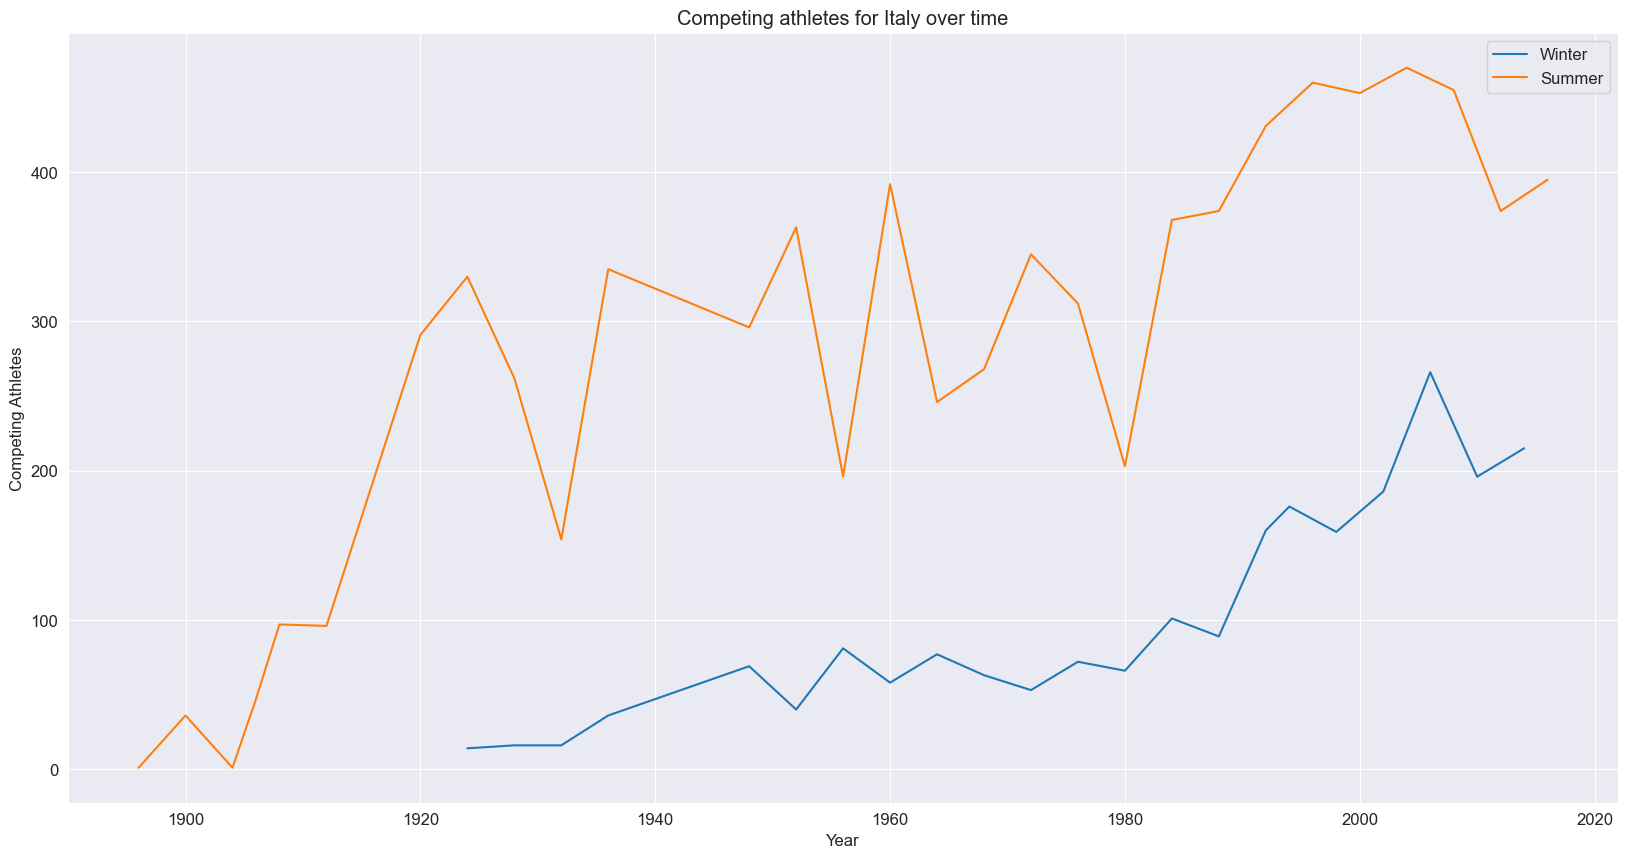

In [469]:
# Italy participation over the years , distinction between Winter and Summer season
ItalyOverTime_Winter = complete_data[(complete_data.Team == 'Italy') & (complete_data.Season == 'Winter')] 
ItalyOverTime_Summer= complete_data[(complete_data.Team == 'Italy') & (complete_data.Season == 'Summer')] 

part = ItalyOverTime_Winter.groupby('Year')['Team'].value_counts()
plt.figure(figsize=(20, 10))
part.loc[:,'Italy'].plot(label= "Winter")


part_summer=ItalyOverTime_Summer.groupby('Year')['Team'].value_counts()
part_summer.loc[:,'Italy'].plot(label= "Summer")

plt.ylabel('Competing Athletes')
plt.xlabel('Year')
plt.title('Competing athletes for Italy over time')
plt.legend()


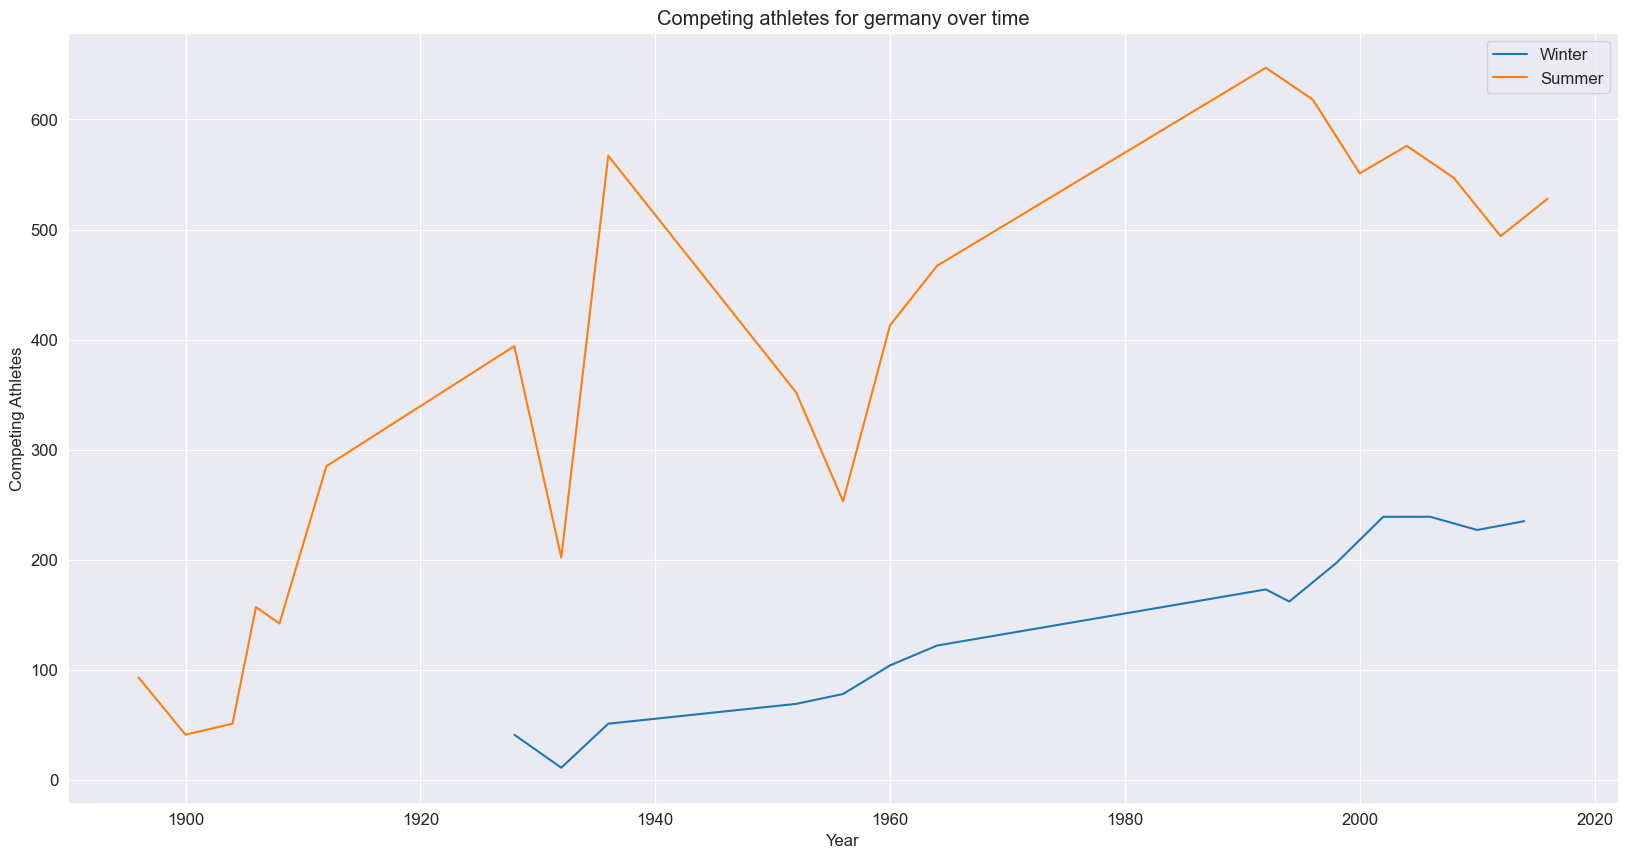

In [470]:
#Germany participation over the years , distinction between Winter and Summer season
GermanyOverTime_Winter = complete_data[(complete_data.Team == 'Germany') & (complete_data.Season == 'Winter')] 
GermanyOverTime_Summer= complete_data[(complete_data.Team == 'Germany') & (complete_data.Season == 'Summer')] 

part = GermanyOverTime_Winter.groupby('Year')['Team'].value_counts()
plt.figure(figsize=(20, 10))
part.loc[:,'Germany'].plot(label= "Winter")


part_summer=GermanyOverTime_Summer.groupby('Year')['Team'].value_counts()
part_summer.loc[:,'Germany'].plot(label= "Summer")

plt.ylabel('Competing Athletes')
plt.xlabel('Year')
plt.title('Competing athletes for germany over time')
plt.legend()


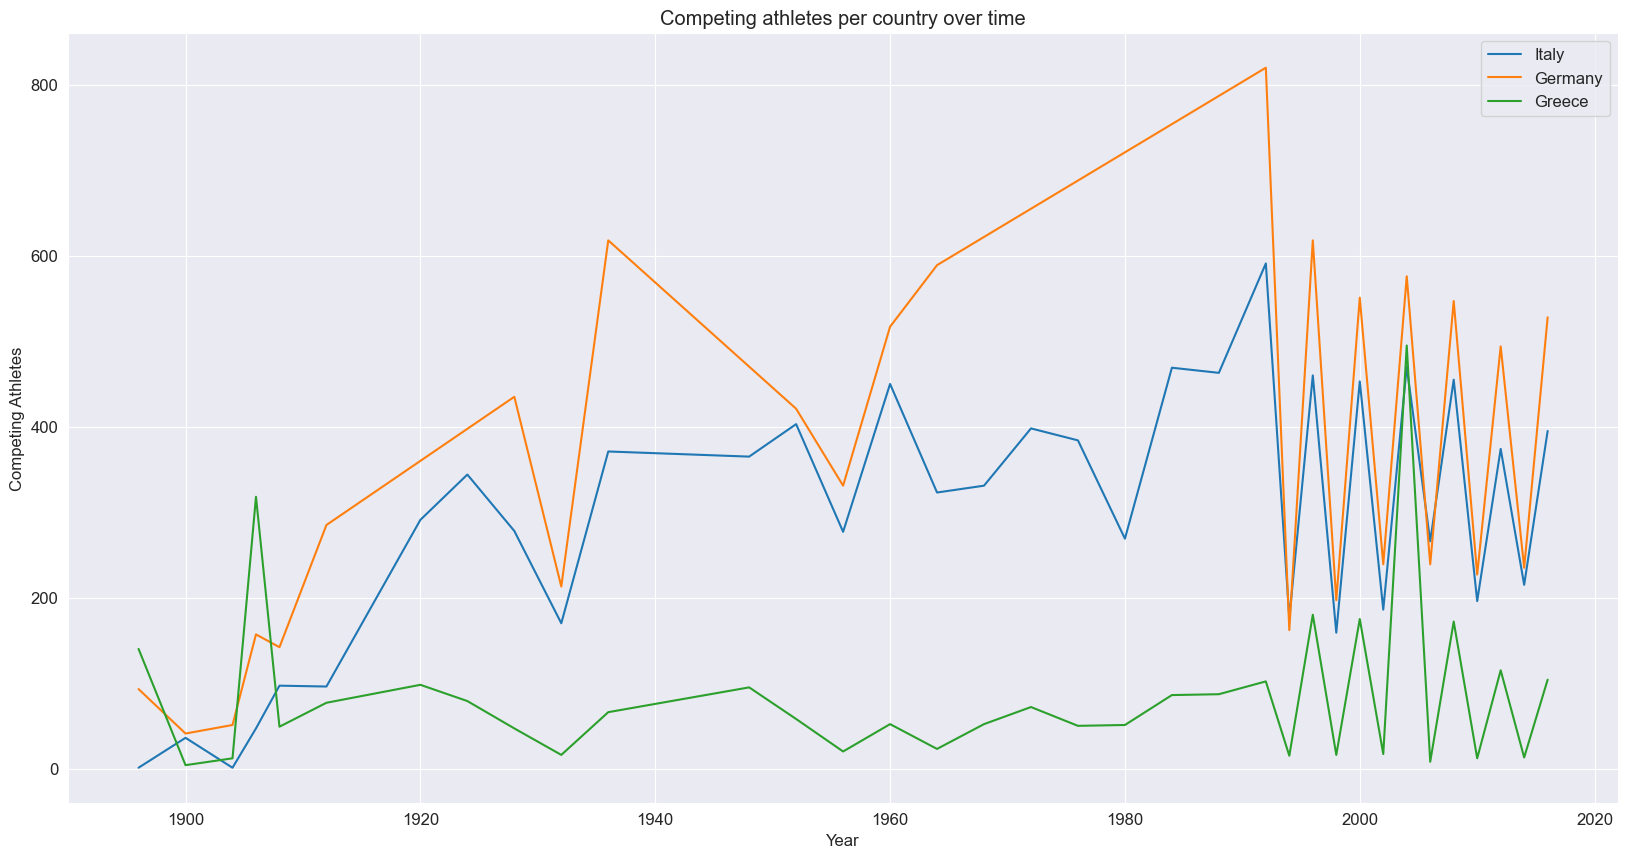

In [471]:
ItalyOverTime = complete_data[(complete_data.Team == 'Italy')]
GermanyOverTime= complete_data[(complete_data.Team == 'Germany')]
GreeceOverTime=complete_data[(complete_data.Team == 'Greece')]

partItaly = ItalyOverTime.groupby('Year')['Team'].value_counts()
partGermany = GermanyOverTime.groupby('Year')['Team'].value_counts()
partGreece = GreeceOverTime.groupby('Year')['Team'].value_counts()

plt.figure(figsize=(20, 10))

partItaly.loc[:,'Italy'].plot(label= "Italy")
partGermany.loc[:,'Germany'].plot(label= "Germany")
partGreece.loc[:,'Greece'].plot(label= "Greece")

plt.ylabel('Competing Athletes')
plt.xlabel('Year')
plt.title('Competing athletes per country over time')
plt.legend()


The amount of competing athletes per country (3 selected randomly; Italy, Germany, Greece). This shows a bit of context regarding the fluctuation of the amount of competetors over the years. It also shows a significant difference between the Summer and Winter games. For Greece for example they did not compete in many of the recent winter games which is the reason for the heavy spikes after the year 1990.

Data madness setup

In [472]:
# Load
complete_data = pd.read_csv("athlete_events.csv")

print(complete_data.columns.values)
#1. ID - Row numbers
#2. Name - Athlete's name
#3. Sex - M or F
#4. Age - Integer
#5. Height - In centimeters
#6. Weight - In kilograms
#7. Team - Team name
#8. NOC - National Olympic Committee 3-letter code
#9. Games - Year and season
#10. Year - Integer
#11. Season - Summer or Winter
#12. City - Host city
#13. Sport - Sport
#14. Event - Event
#15. Medal - Gold, Silver, Bronze, or NA

['ID' 'Name' 'Sex' 'Age' 'Height' 'Weight' 'Team'
 'NOC' 'Games' 'Year' 'Season' 'City' 'Sport'
 'Event' 'Medal']


In [473]:
# Functions

# Medal conversion to numeric columns
def convert_medals(data):
    types = ['NA', 'Gold', 'Silver', 'Bronze']

    cat_type = CategoricalDtype(categories=types)

    data['Medal'] = data['Medal'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='mdl',
                          columns=['Medal'],
                          drop_first=True)

    return data

In [474]:
# Order & group by queries

# Medals
Medals = convert_medals(complete_data)
Medals = Medals[Medals.Year > 2000]
Medals = Medals[['Name', 'Team', 'Games', 'Sport', 'mdl_Gold', 'mdl_Silver', 'mdl_Bronze', "Age"]]

Medal_counts = Medals.groupby(['Name', 'Team', 'Games', 'Sport'], as_index=False).sum()
Medal_counts = Medal_counts.sort_values('Games')


In [475]:
mc = Medal_counts[Medal_counts["Age"] > 0]
# filter out the ones without a medal, gold + silver + bronze = 0
mc = mc[mc["mdl_Gold"] + mc["mdl_Silver"] + mc["mdl_Bronze"] == 0]

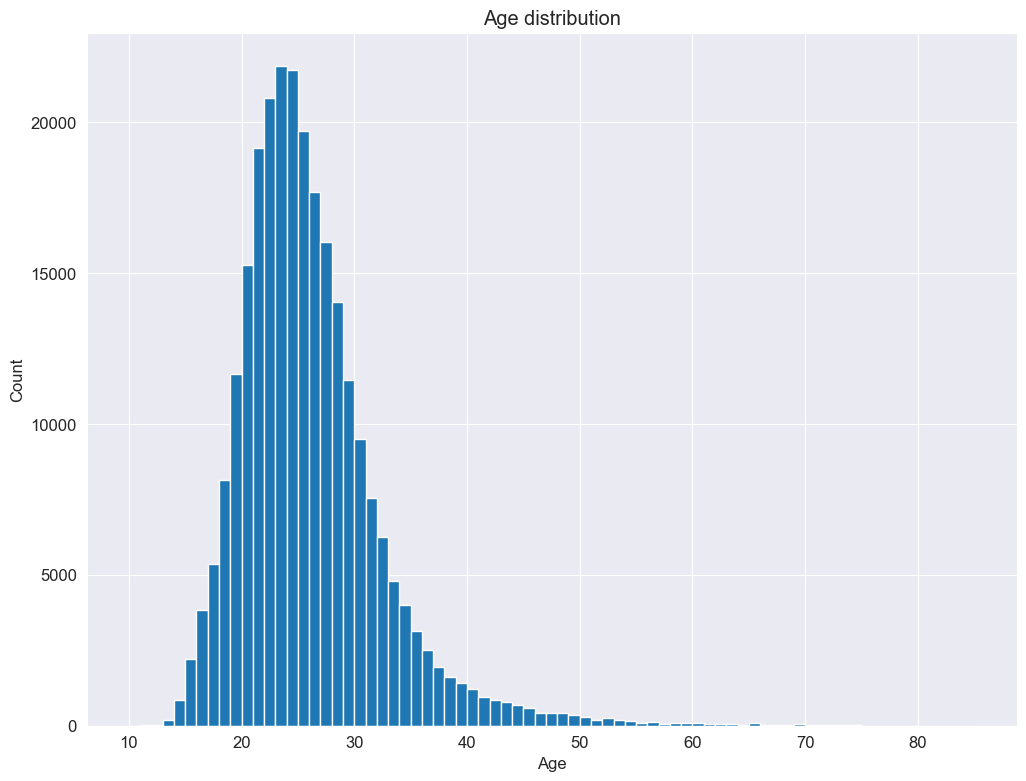

In [476]:
# age histogram
plt.hist(complete_data.Age, bins=75, range=(10, 85))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.show()

In [477]:
min(complete_data.Age.unique())

10.0

In [478]:
max(complete_data.Age.unique())

97.0

In [479]:
# dropna on medal
meds = complete_data.dropna(subset=['Medal'])
# get diff between complete data and meds
nomeds = pd.concat([complete_data, meds]).drop_duplicates(keep=False)

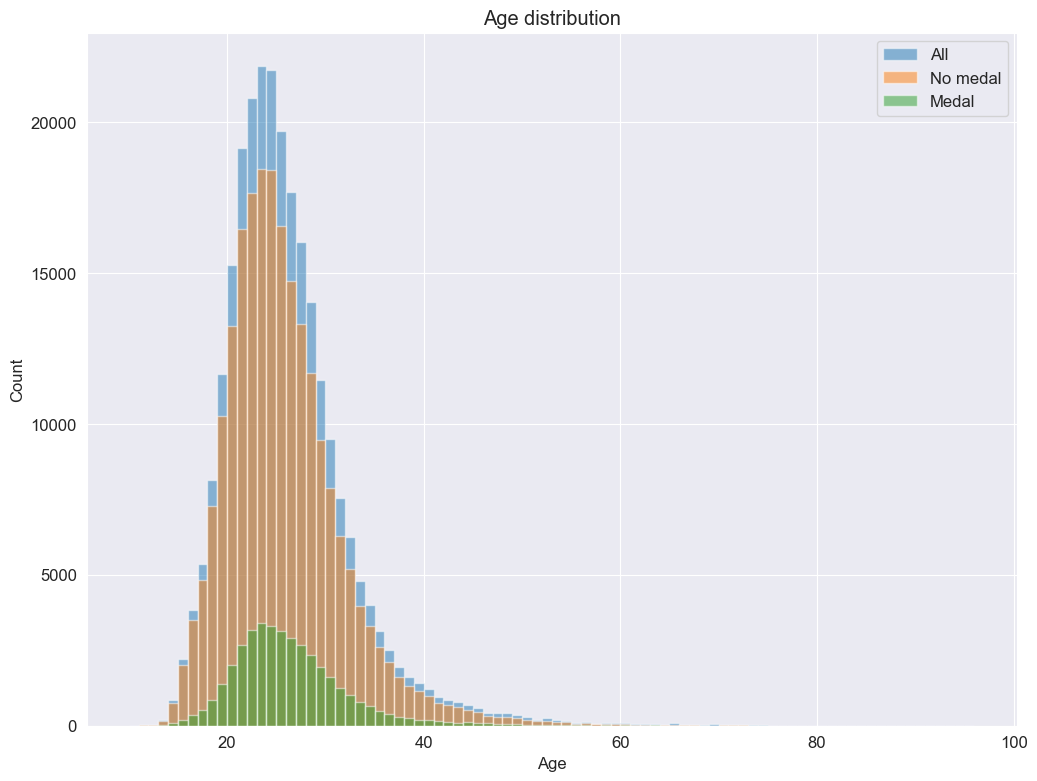

In [480]:
# make 2 histograms with mc and md, age
# do subplots

fig = plt.figure()
plt.hist(complete_data.Age, bins=range(10, 97), alpha=0.5, label='All')
plt.hist(nomeds.Age, bins=range(10, 97), alpha=0.5, label='No medal')
plt.hist(meds.Age,  bins=range(10, 97), alpha=0.5, label='Medal')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.legend(loc='upper right')
plt.show()


In [481]:
meds

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
41,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271078,135553,Galina Ivanovna Zybina (-Fyodorova),F,25.0,168.0,80.0,Soviet Union,URS,1956 Summer,1956,Summer,Melbourne,Athletics,Athletics Women's Shot Put,Silver
271080,135553,Galina Ivanovna Zybina (-Fyodorova),F,33.0,168.0,80.0,Soviet Union,URS,1964 Summer,1964,Summer,Tokyo,Athletics,Athletics Women's Shot Put,Bronze
271082,135554,Bogusaw Zych,M,28.0,182.0,82.0,Poland,POL,1980 Summer,1980,Summer,Moskva,Fencing,"Fencing Men's Foil, Team",Bronze
271102,135563,Olesya Nikolayevna Zykina,F,19.0,171.0,64.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Women's 4 x 400 metres Relay,Bronze


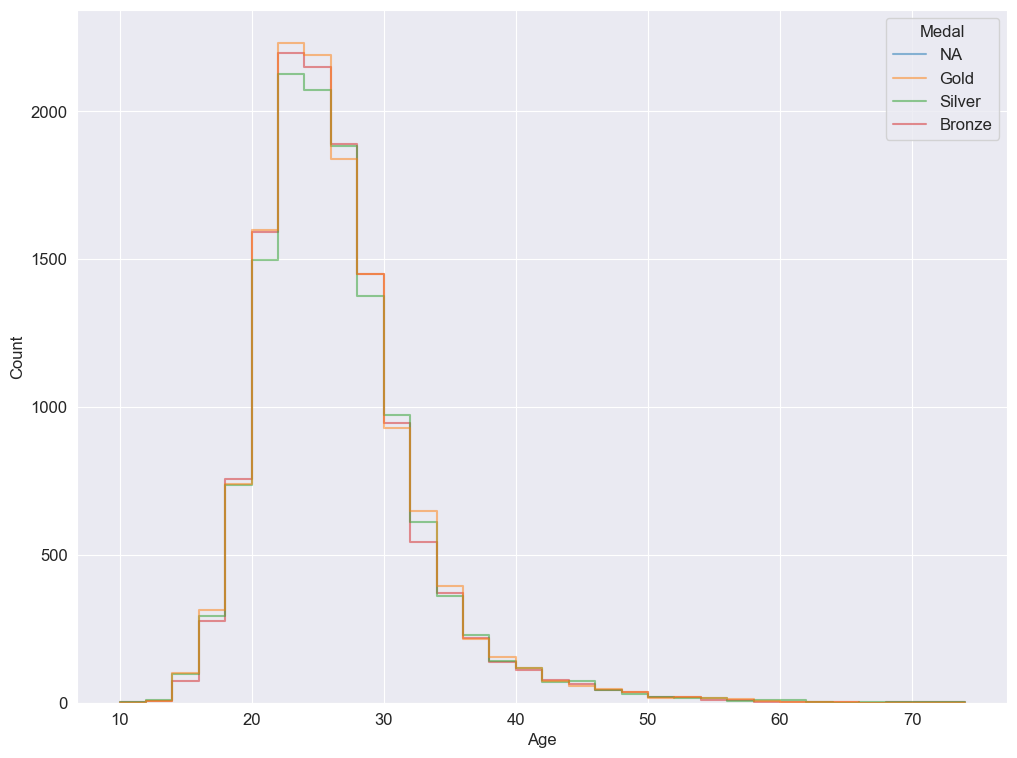

In [482]:
sns.histplot(complete_data, x="Age", hue="Medal",
            alpha=0.5,
            binwidth=2, element="step", fill=False)
plt.show()

In [483]:
def getData(data, random_state=42, test_size=0.3):
    # replace na values in medal with ""
    df = data.copy()
    df['Medal'] = df['Medal'].cat.add_categories('NoMedal')
    df['Medal'].fillna('NoMedal', inplace =True)

    # train test pslit, X = all columns except Team, Games, Sport, Event, Medal, ID, City, Year, Season
    # y = Medal
    X = df.drop(['Team', 'Games', 'Sport', 'Event', 'Medal', "ID", "City", "Year", "Season"], axis=1)
    print(X.columns)
    y = df['Medal']

    # labelencode y
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    # print le.classes_
    print(le.inverse_transform([0, 1, 2, 3]))

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # ordinal encode the categorical columns of X_train and X_test
    # fit ordinal encoder on x train
    oe = preprocessing.OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    # fit on X_train
    oe.fit(X_train)

    # transform X_train and X_test
    X_train = oe.transform(X_train)
    X_test = oe.transform(X_test)



    return X_train, X_test, y_train, y_test,le, oe



In [484]:
X_train, X_test, y_train, y_test, le, oe = getData(complete_data)



Index(['Name', 'Sex', 'Age', 'Height', 'Weight', 'NOC'], dtype='object')
['Bronze' 'Gold' 'NoMedal' 'Silver']


In [485]:
# train random forest classifier
rfc = HistGradientBoostingClassifier(random_state=42)
rfc.fit(X_train, y_train)
# predict
y_pred = rfc.predict(X_test)
# accuracy score
accuracy_score(y_test, y_pred)

0.8536177537345546

In [486]:
# predict new instance
# make a new dataframe with the same columns as X
Xnew = complete_data.drop(['Team', 'Games', 'Sport', 'Event', 'Medal', "ID", "City", "Year", "Season"], axis=1)
# new row dictionary with columns from Xnew
newrow = {"Name": "Fabian", "Sex":"M", "Age":"20", "Height":175, "Weight":85, "NOC":"CHN"}
# add new row to Xnew
Xnew = Xnew.append(newrow, ignore_index=True)
# get last row
Xnew = Xnew.tail(1)
Xnew

C:\Users\fabia\AppData\Local\Temp\ipykernel_2692\939977120.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Xnew = Xnew.append(newrow, ignore_index=True)


,Name,Sex,Age,Height,Weight,NOC
271116,Fabian,M,20,175.0,85.0,CHN


In [487]:
# predict Xnew
xinv = oe.transform(Xnew)
ynew = rfc.predict(xinv)
# inverse transform ynew
le.inverse_transform(ynew)


array(['NoMedal'], dtype=object)

In [488]:
# predict proba of Xnew
ynew = rfc.predict_proba(xinv)
# create dataframe from ynew
ynewdf = pd.DataFrame(ynew, columns=le.classes_)
ynewdf


,Bronze,Gold,NoMedal,Silver
0,0.031418,0.016228,0.931652,0.020701
